In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
import imageio as io
import glob 
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Loading BokehJS ...

In [3]:
# get location of all stations and transform to geopandas frame

df_stations = pd.read_csv('data/stations_US.csv', index_col=0)

df_stations = gpd.GeoDataFrame(
    df_stations, geometry=gpd.points_from_xy(df_stations['lon'], df_stations['lat']))
print('total number of stations: ' + str(len(df_stations)))

all_stations = list(df_stations['station'])
df_stations.head()

total number of stations: 2734


,station,lon,lat,geometry
0,PADK,-176.6460,51.8780,POINT (-176.64600 51.87800)
1,PAKH,-154.1800,56.9400,POINT (-154.18000 56.94000)
2,PAUT,-165.6041,54.1446,POINT (-165.60410 54.14460)
3,PALP,-150.9447,70.3443,POINT (-150.94470 70.34430)
4,PAFM,-157.8575,67.1063,POINT (-157.85750 67.10630)


In [4]:
# get world map

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [5]:
# get data of air pressure for all stations

all_files = glob.glob('data/*.txt')
all_files.sort()

df_data = pd.read_csv(all_files[0], header=0, skiprows=0, usecols=(0,4,5))
for i in range(1, len(all_files)):
    df_data = df_data.append(pd.read_csv(all_files[i], header=0, skiprows=0, usecols=(0,4,5)))

df_data.rename(columns={'valid(UTC)': 'time', 'pres1':'pressure'}, inplace=True)
df_data['time'] =  pd.to_datetime(df_data['time'])
df_data.head()

,station,time,pressure
0,12N,2022-01-15 00:00:00,29.274
1,12N,2022-01-15 00:01:00,29.275
2,12N,2022-01-15 00:02:00,29.277
3,12N,2022-01-15 00:03:00,29.277
4,12N,2022-01-15 00:04:00,29.277


In [6]:
# make a frame with station names as column and time as row

date_start = datetime.datetime(2022, 1, 15, 0, 0, 0)
date_end = datetime.datetime(2022, 1, 16, 0, 0, 0)

days = pd.date_range(date_start, date_end, freq='1min')

data = np.random.randint(len(days))
df_empty = pd.DataFrame({'time': days})

df_empty.head()

,time
0,2022-01-15 00:00:00
1,2022-01-15 00:01:00
2,2022-01-15 00:02:00
3,2022-01-15 00:03:00
4,2022-01-15 00:04:00


In [7]:
# fill in pressure data

station_with_raw_data = list(df_data['station'].unique())
for s in all_stations:
    if s in station_with_raw_data:
        tmp_pressure = df_data[df_data['station'] == s]['pressure']
        df_empty[s] = tmp_pressure

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [8]:
# clean nulls

df_series = df_empty.copy()
df_series = df_series[df_series.columns[df_series.isnull().mean() < 0.9]]
station_with_series_data = df_series.columns[1:]
df_series.head()

,time,PANC,PABR,PABE,PABT,PACV,PASC,PAEG,PAFA,PABI,...,GEY,LND,LAR,RWL,RIW,RKS,SHR,TOR,WRL,P60
0,2022-01-15 00:00:00,29.270,30.238,29.299,29.016,29.486,30.113,28.654,29.072,28.207,...,26.365,24.796,23.177,23.676,24.781,23.693,26.374,26.035,26.112,22.768
1,2022-01-15 00:01:00,29.270,30.238,29.300,29.016,29.486,30.112,28.652,29.071,28.208,...,26.365,24.796,23.177,23.677,24.781,23.692,26.373,26.036,26.113,22.768
2,2022-01-15 00:02:00,29.269,30.238,29.300,29.016,29.487,30.114,28.651,29.074,28.208,...,26.365,24.795,23.177,23.677,24.781,23.692,26.372,26.037,26.112,22.768
3,2022-01-15 00:03:00,29.269,30.239,29.300,29.017,29.487,30.113,28.651,29.076,28.209,...,26.365,24.795,23.177,23.678,24.781,23.691,26.372,26.038,26.112,22.768
4,2022-01-15 00:04:00,29.268,30.239,29.301,29.017,29.487,30.111,28.652,29.076,28.209,...,26.365,24.796,23.177,23.677,24.781,23.692,26.372,26.039,26.113,22.768


In [48]:
# visualize pressure gradients for a station

def show_gradient(s):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df_series['time'], -1 + df_series[s]/df_series[s][0], label='shifted relative pressure', color='dodgerblue')
    ax.plot(df_series['time'], df_series[s].pct_change(periods=5), '--', label='percentage change', color='darkorange')

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=6))
    ax.set_xlabel('time')
    ax.set_ylabel('relative pressure')
    plt.gcf().autofmt_xdate() # Rotation
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title('Jan.15, 2022, ' + s)
    plt.show()

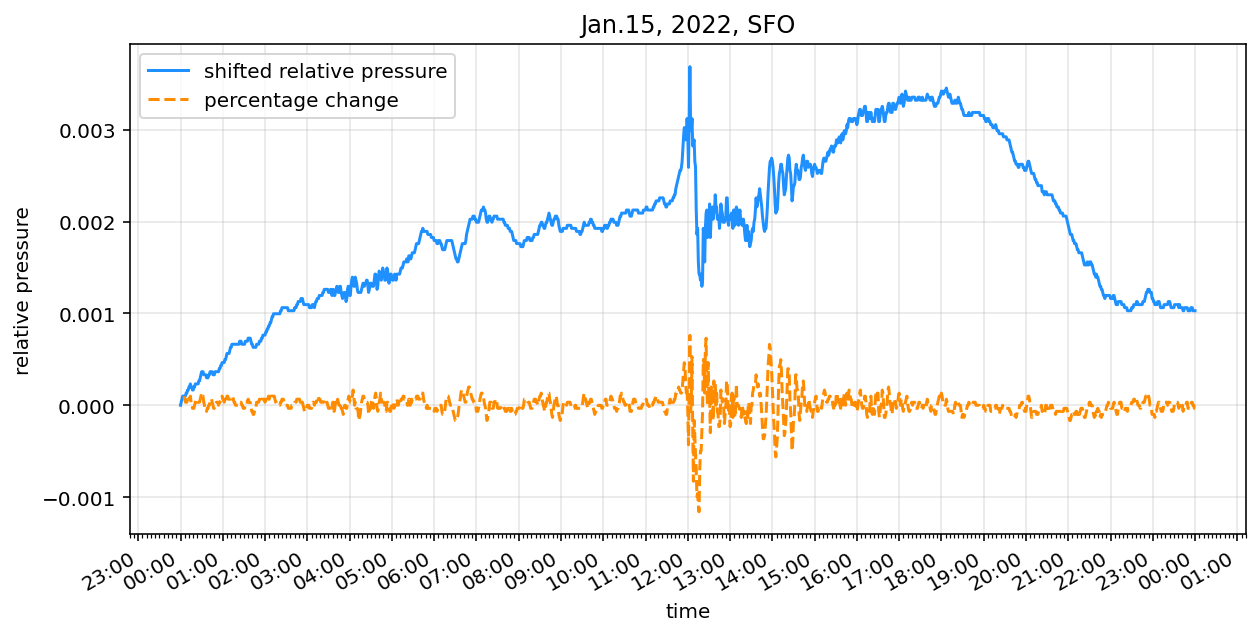

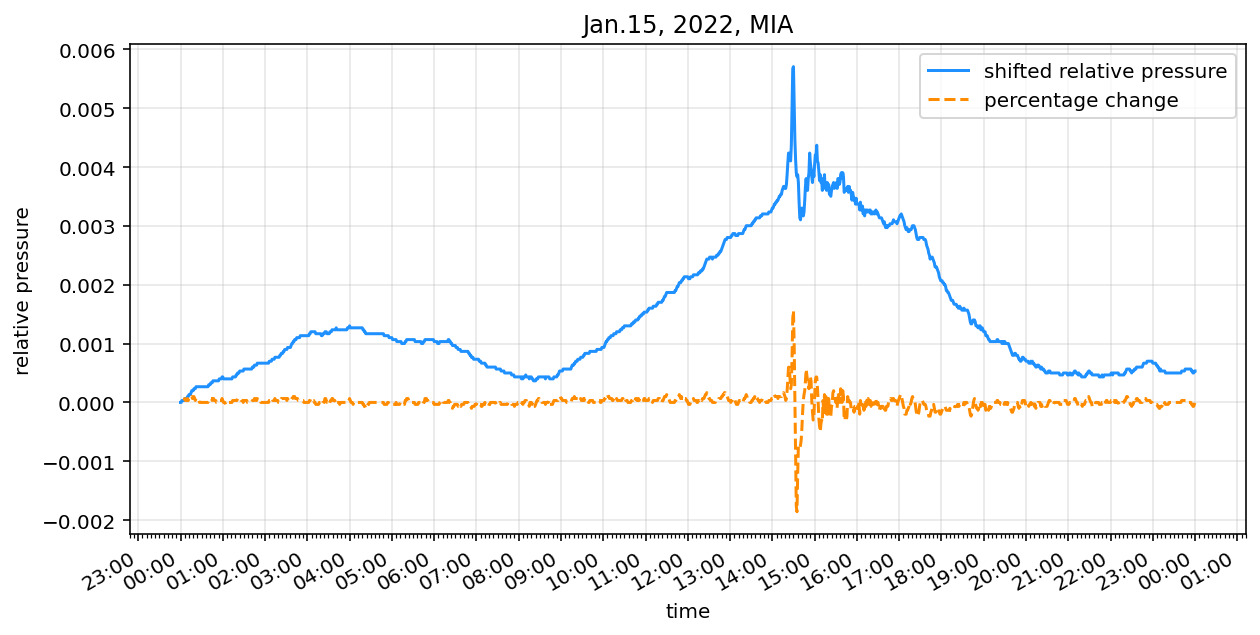

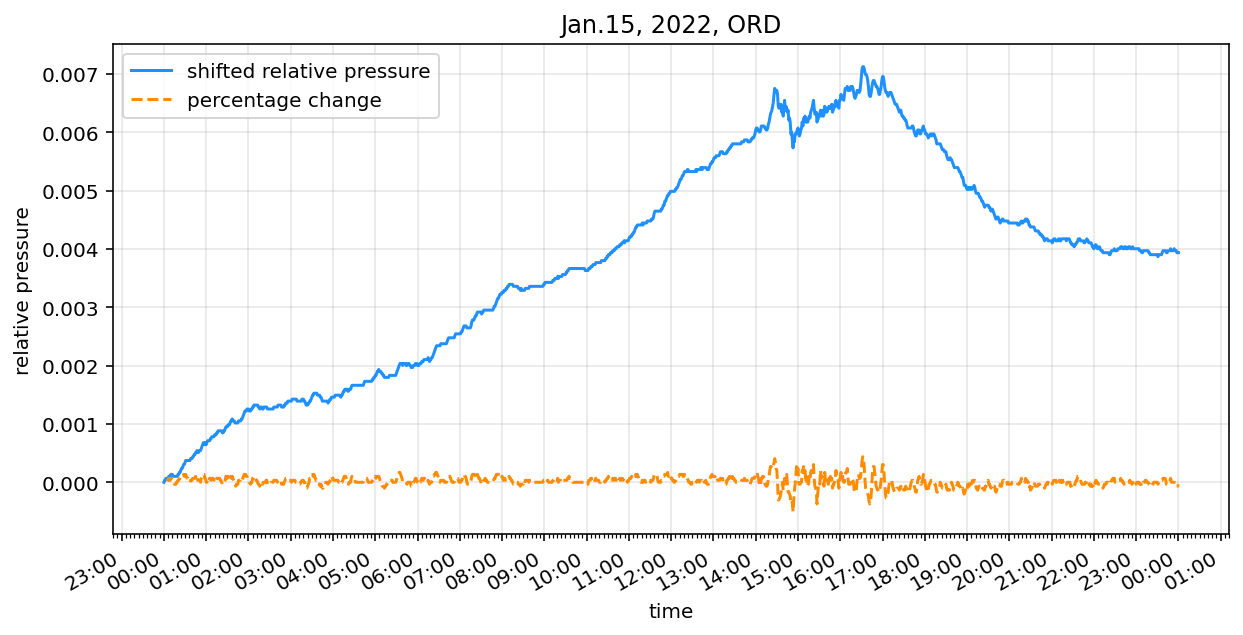

In [50]:
show_gradient('SFO')
show_gradient('MIA')
show_gradient('ORD')

In [11]:
# calculate percent change and find time of shock wave arriving

tmp = []
tmp_raw = []
for s in all_stations:
    if s in station_with_series_data:
        changes = df_series[s].pct_change(periods=5)
        t_min = df_series['time'].loc[changes == np.min(changes)] # TimeStamp
        tmp_raw.append(pd.Timestamp(t_min.values[0]))
        tmp.append((pd.Timestamp(t_min.values[0]) - datetime.datetime(2022, 1, 15, 0, 0, 0)).total_seconds())
    else:
        tmp_raw.append(0)
        tmp.append(0)

In [12]:
# create shock wave time columns

df_stations['t_shock'] = tmp
df_stations['t_shock_raw'] = tmp_raw
df_stations = df_stations[df_stations['t_shock']>0]
df_stations.head()

,station,lon,lat,geometry,t_shock,t_shock_raw
6,PANC,-150.0261,61.1697,POINT (-150.02610 61.16970),46560.0,2022-01-15 12:56:00
14,PABR,-156.7922,71.2826,POINT (-156.79220 71.28260),26460.0,2022-01-15 07:21:00
16,PABE,-161.8264,60.7858,POINT (-161.82640 60.78580),45840.0,2022-01-15 12:44:00
17,PABT,-151.5189,66.9165,POINT (-151.51890 66.91650),48420.0,2022-01-15 13:27:00
34,PACV,-145.4511,60.4889,POINT (-145.45110 60.48890),46860.0,2022-01-15 13:01:00


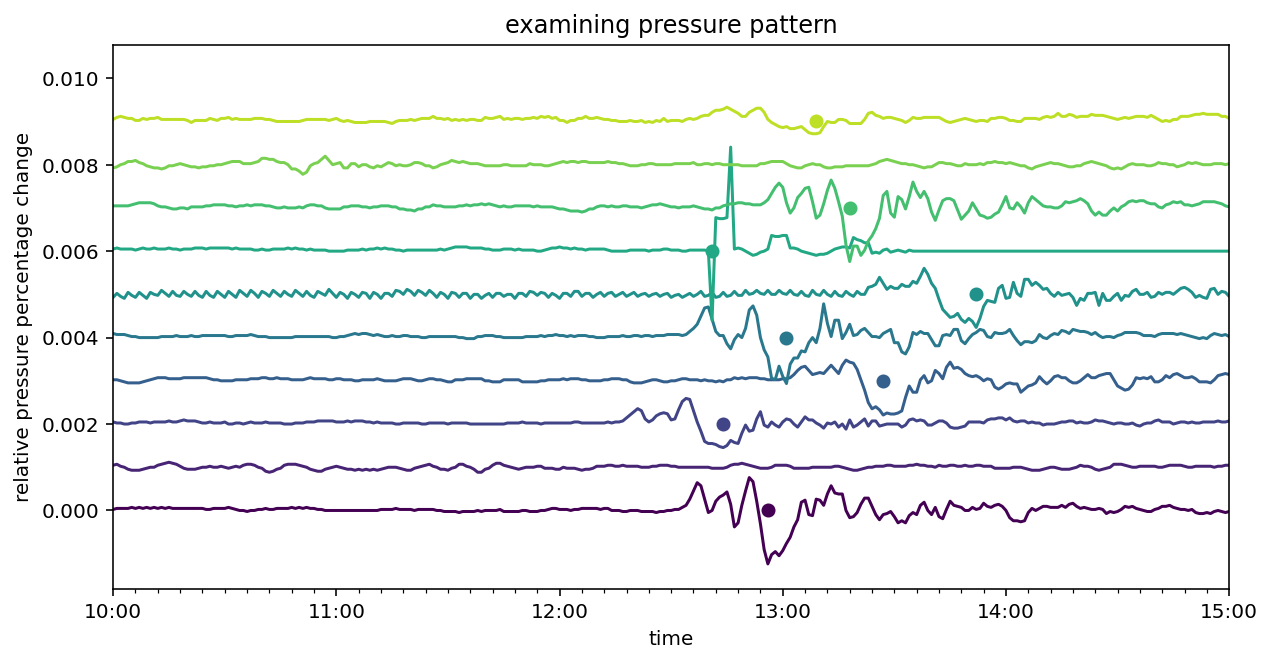

In [42]:
# visualize pressure gradients for all stations

stations = df_series.columns[1:]
fig, ax = plt.subplots(figsize=(10,5))
cm = matplotlib.cm.get_cmap()
n_lines = 10
for i in range(n_lines):
    ax.plot(df_series['time'], i/1000 + 0.7 * df_series[stations[i]].pct_change(periods=period), color=cm(i/n_lines))
    ax.plot(df_stations[df_stations['station']==stations[i]]['t_shock_raw'], i/1000, 'o', color=cm(i/n_lines))

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=6))
ax.set_xlabel('time')
ax.set_ylabel('relative pressure percentage change')
plt.title('examining pressure pattern')
plt.xlim(datetime.datetime(2022, 1, 15, 10, 0), datetime.datetime(2022, 1, 15, 15, 0))
plt.show()

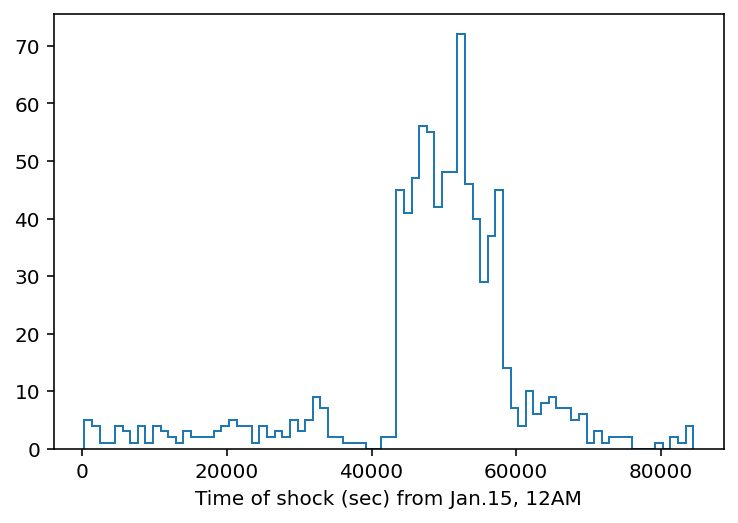

In [14]:
# distribution of shock wave time?

plt.hist(df_stations['t_shock'],bins=80, histtype='step')
plt.xlabel('Time of shock (sec) from Jan.15, 12AM')
plt.show()

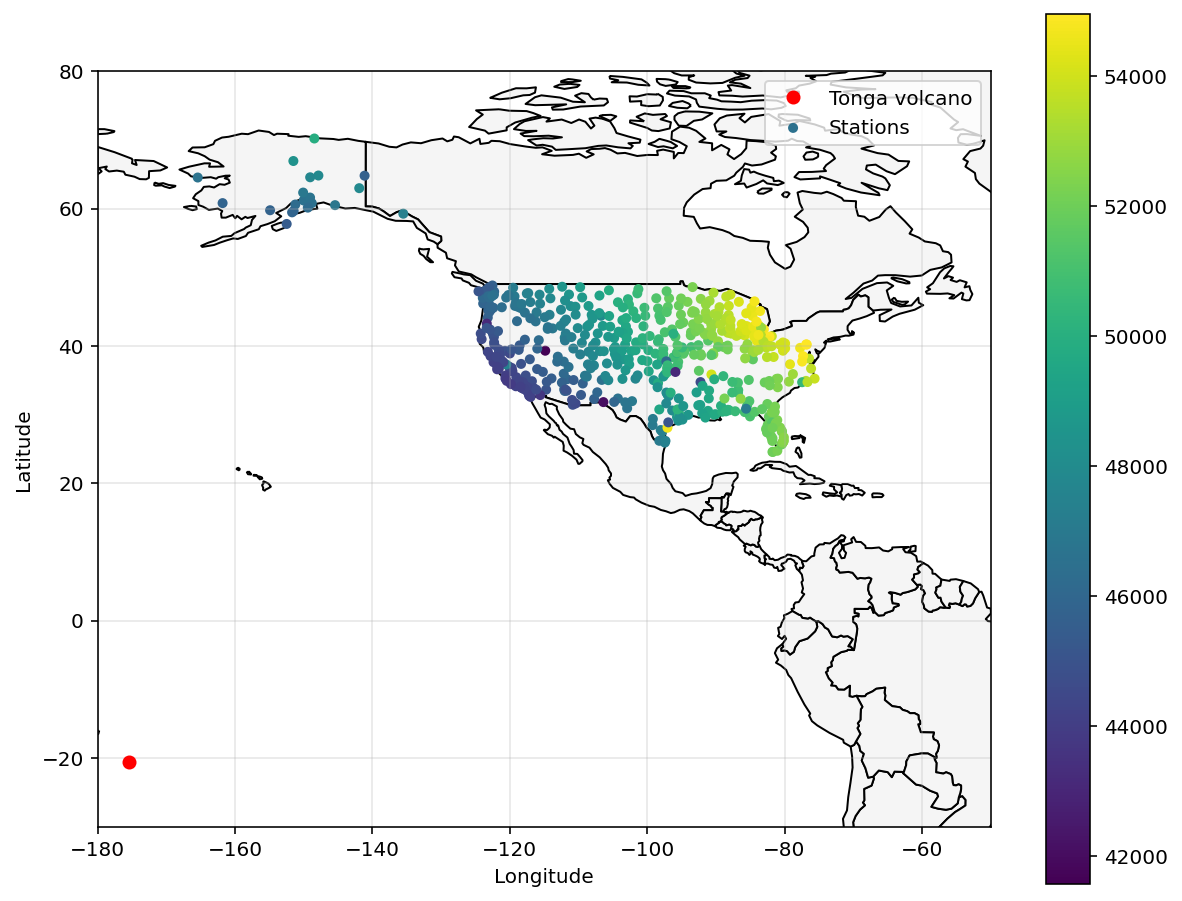

In [40]:
# visualize shock wave!

cut = (df_stations['t_shock'] > 40000) & (df_stations['t_shock'] < 55000)
fig, ax = plt.subplots(figsize=(10,8))
df_world.plot(ax=ax, color='whitesmoke', edgecolor='black')
im = df_stations[cut].plot(ax=ax, column=df_stations['t_shock'][cut], 
                           label='Stations', cmap='viridis', legend=True, markersize=16)
ax.plot(-175.385,-20.55, 'o', color='red', label='Tonga volcano')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(-180, -50)
plt.ylim(-30,80)
plt.show()

In [37]:
# save shock wave!

for t in np.arange(40000, 56000, 200):
    fig, ax = plt.subplots(figsize=(8,6))
    cm = matplotlib.cm.get_cmap('coolwarm')
    df_world.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5)
    for s in range(len(df_stations)):
        station = df_stations.iloc[s]
        if 40000 < station['t_shock'] < 55000:
            cval = 1 - np.abs(station['t_shock'] - t)/12000
            color = cm(cval)
            ax.plot(station['lon'],station['lat'],'o',color=color, markersize=5*cval**2)
        
    ax.plot(-175.385,-20.55, '*', color='m', markersize=10, label='Tonga volcano')
    ax.plot()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, -50)
    ax.set_ylim(-30,80)
    ax.set_title(str(datetime.datetime(2022, 1, 15, 15, 0) + datetime.timedelta(seconds=int(t))) + ' (UTC)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.legend(prop={'size':15})
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    
    plt.savefig('data_animation/frame_' +str(t).zfill(2) + '.png', dpi=150)
    plt.close()

In [38]:
# save png as movie

images = []
fs = glob.glob('data_animation/*.png')
fs.sort()
for f in fs:
    images.append(io.imread(f))

In [39]:
# export to gif

io.mimsave('final_cut.gif', images, fps=40)

<img src="final_cut.gif">